# Create a mosaic image from SDSS imaging

The Sloan Digital Sky Survey (SDSS) has taken images of more than one-quarter of the entire sky. The most recent release of completed SDSS images occurred with Data Release 9 (DR9), although photometric parameters for individual sky objects were reprocessed from these images as part of Data Release 13. All images have been calibrated, sky-substracted, and corrected, and are referred to as <strong><em>corrected frames</em></strong>.

SciServer makes all SDSS DR9 corrected frames available as FITS files through a shared data volume called <code style='color:#ff0000'>SDSS DR9 Imaging</code>. If you checked that box when you created the container, you will see a directory at the top level called <code style='color:#ff0000'>dr9_imaging</code>. This notebook will copy the necessary FITS files from there.

This Example Notebook shows you how to make a mosiac image from SDSS data. The notebook uses the <strong><em>Montage</em></strong> toolkit to build the mosaic from DR9 images. Make sure you are running it in a container with the <code style='color:#ff0000'>Montage</code> compute image selected. 

For the notebook to work correctly, you will need to have created a User Volume called <code style='color:#ff0000'>montage_temp</code> and mounted it on this container. If you have not created and mounted a user volume with that name, please create it now, delete your Compute Container, and create a new one with both the <code style='color:#ff0000'>SDSS DR9 Imaging</code> data volume and your <code style='color:#ff0000'>montage_temp</code> user volume mounted.

This notebook in the shared data volume is read-only, but if you copy it into one of your User Volumes you can edit and save it. You may need to copy it from the SciServer Dashboard rather than from the Compute application. You are welcome to use this Example Notebook as a template to build your own notebooks.

# Install packages

Although the Montage code will work automatically if you run this notebook in the <code style='color:#ff0000'>Montage</code> compute image, you still need to install the Python packages <code style='color:#ff0000'>pyvo</code> (for working with Virtual Observatory services) and <strong>version 3.0.1</strong> of <code style='color:#ff0000'>matplotlib</code>.

The first time you run this notebook in a new container, be sure to run the following code cells, which use <code style='color:#ff0000'>pip install</code> to get the correct packages. You can then comment those commands out; you will only need to run these again if you close the container and open a new one.

In [1]:
#!pip install pyvo

In [2]:
#!pip install matplotlib==3.0.1

# Import packages

<strong>Important:</strong> if you just ran the above commands to install <code style='color:#ff0000'>pyvo</code> and <code style='color:#ff0000'>matplotlib==3.0.1</code> for the first time, you will need to restart the kernel before proceeding. Do that by going to Kernel -> Restart in the menu above. Then start again from this point in the notebook.

Now that we have installed all the packages we need, in their correct versions, import the packages so we can use them in this notebook.

In [3]:
import os
import pandas
import pyvo
import numpy as np
import shutil
import bz2
import io
from astropy.io import fits
import warnings
#import sdss_archive
import datetime
from pprint import pprint
import bz2
from matplotlib import pyplot as plt
from astropy.io import ascii
from astropy import wcs
from matplotlib.colors import LogNorm
from SciServer import Authentication

from MontagePy.main    import *
from MontagePy.archive import *

from IPython.display import Image

start = datetime.datetime.now()
print('Start: ' + str(start))

Start: 2020-06-18 15:12:09.216045


# Define mosaic parameters

Define the parameters of the mosaic:
<ol>
    <li><strong>location</strong>: can be either an object name (e.g. M51) or an ra/dec position (e.g. 202.48417, 47.23056)</li>
    <li><strong>size</strong>: the size of the desired area in square degrees</li>
    <li><strong>band</strong>: the SDSS wavelength band to use to make the mosaic; must be one of {<em>u</em>, <em>g</em>, <em>r</em>, <em>i</em>, <em>z</em>}</li>
    <li><strong>workdir_name</strong>: the name of the directory under the <code style='color:#ff0000'>montage_temp</code> user volume into which results should be written</li> 
</ol>


In [4]:
location  = "M51"
size      = 0.25
band      = "g"
#searchstring = "CIRCLE('ICRS',202.48417,47.23056,0.4))=1"
workdir_name = location + band
#workdir   = "M51g"
print('Defined parameters for mosaic!')
paramlist = [
    {'location': location},
    {'size': size}, 
    {'band': band}, 
    {'workdir_name': workdir_name},
    #{'searchstring': searchstring}
]

for x in paramlist:
    pprint(x)

Defined parameters for mosaic!
{'location': 'M51'}
{'size': 0.25}
{'band': 'g'}
{'workdir_name': 'M51g'}


## Set up working environment

Montage operates at the level of directories rather than individual files. So to use this notebook, you must have your directory structure set up correctly. The parameter <code style='color:#ff0000'>workdir_name</code> that you set in the previous code cell is the top-level directory under which output will be written. Run the next code cell to set up the directory structure that Montage will need to produce results.

In [5]:
user=Authentication.getKeystoneUserWithToken(Authentication.getToken()).userName

workdir = '/home/idies/workspace/Temporary/'+user+'/montage_temp/'+workdir_name+'/'
print(workdir)
os.makedirs(workdir,exist_ok=True)

#os.chdir(workdir)
for z in ['raw', 'corrected', 'projected', 'diffs']:
    os.makedirs(workdir+z,exist_ok=True)
print('Done!')

os.chdir(workdir)

os.listdir()


/home/idies/workspace/Temporary/raddick/montage_temp/M51g/
Done!


['raw',
 'projected',
 'diffs',
 'corrected',
 'region.hdr',
 'rimages.tbl',
 'pimages.tbl',
 'fp_2mass.tbl',
 'uncorrected.png',
 'uncorrected.fits',
 'uncorrected_area.fits']

# Retrieving Data from an Archive

Now the first bit of Montage processing.  Montage uses standard FITS files throughout and FITS files have all the metadata describing the image (for us that mainly means pixel scale, projection type and center, rotation and so on).  To drive the processing we need a "FITS header" specification from the user, which we capture in a header "template" file that looks just like a FITS header though with newlines (FITS headers have fixed 80-character card images with no line breaks). 

The mHdr routine is a utility that creates a simple FITS header template with limited control over all the above (<i>e.g.</i> the projection is always gnomonic (TAN)).  Other common options are to use a header extracted from some pre-existing FITS file (to create a matching mosaic) or to use mMakeHdr, which fits a bounding box around a set of images (usually the ones you are about to mosaic).

We also use the location and size to retrieve the data we want from a remote archive.  Montage provides an image metadata search service (using mSearch &mdash; a very fast R-Tree / memory-mapped utility &mdash; for most datasets).  This service returns URLs for all the images covering the region of interest, which are then downloaded.

There are many other ways to find images.  The International Virtual Astronomy Alliance (IVOA) has developed a couple of standards for querying metadata (Simple Image Access: SIAP and Table Access Protocol: TAP) which many data providers support.  Our service is focused on a few large uniform datasets (2MASS, DSS, SDSS, WISE).  Other datasets require more care.  For instance, simply downloading all pointed observations of a specific region for a non-survey instrument will include a wide range of integration times (and therefore noise levels) and the mosaicking should involve user-specified weighting of the images (which Montage supports but does not define).

# Get FITS header for new co-added image

Like any FITS file, the mosaic image to be generated will need a header. The next code cell generates the fits header using Montage's <code style='color:#ff0000'>mHdr</code> module.

In [6]:
print('Get FITS header for mosaic image...')
#os.chdir(workdir)
rtn = mHdr(location, size, size, "region.hdr")

print('Done')
#os.getcwd()

Get FITS header for mosaic image...
Done


# Find what images SDSS has for this object

The next code cell looks up what SDSS images (FITS files) are available to tile the area requested (center point + radius). To find these images, the code uses an API provided by Montage and hosted at IPAC.   

<strong>Suggestion:</strong> it would be faster and more stable to look up the available imaging with the <code style='color:#ff0000'>SkyServer.CasJobs</code> module instead.

In [7]:
debug = 1
getfiles = []

print('looking up SDSS coverage of this location...')

# Build the URL to get image metadata
url = "http://montage.ipac.caltech.edu/cgi-bin/ArchiveList/nph-archivelist?survey=SDSSDR9+" \
    + urllib.parse.quote_plus(band) \
    + "&location=" \
    + urllib.parse.quote_plus(location) \
    + "&size=" \
    + str(size) + "&units=deg&mode=JSON"
fjson = urllib.request.urlopen(url)#.read()
print(url)
data = json.load(fjson)
for i in range(0, len(data)):
    archivefilelink = data[i]['url']
    archivefilelink = archivefilelink.replace('/dr10/','/dr9/')
    getfiles.append(archivefilelink)    

nimages = len(getfiles)
print('Will get {0:,.0f} image(s):'.format(nimages))
for x in getfiles:
    print(x.split('/')[-1])

looking up SDSS coverage of this location...
http://montage.ipac.caltech.edu/cgi-bin/ArchiveList/nph-archivelist?survey=SDSSDR9+g&location=M51&size=0.25&units=deg&mode=JSON
Will get 7 image(s):
frame-g-003716-6-0116.fits.bz2
frame-g-003716-6-0117.fits.bz2
frame-g-003650-1-0088.fits.bz2
frame-g-003716-6-0118.fits.bz2
frame-g-003699-6-0099.fits.bz2
frame-g-003699-6-0100.fits.bz2
frame-g-003699-6-0101.fits.bz2


# Copy images to "raw" directory

Now let's copy the images from the mounted <code style='color:#ff0000'>dr9_imaging</code> directory to the working directory space.

Note that this will work ONLY if you checked the checkbox to mount the  <code style='color:#ff0000'>SDSS DR9 Imaging</code> data volume at the time you created the container.

In [8]:
rawfile_dir = workdir + 'raw/'

for archivefilelink in getfiles:
    filename = archivefilelink.split('/')[-1].replace(".bz2","")
    newlocation = archivefilelink.replace('http://data.sdss3.org/sas/dr9/boss/photoObj/frames/301',
                                          '/home/idies/workspace/dr9_imaging/boss/photoObj/frames/301')
    #print(newlocation)
    with bz2.BZ2File(newlocation) as fr, open(rawfile_dir+filename,"wb") as fw:
        shutil.copyfileobj(fr,fw)    
    
print('Done!')
print(rawfile_dir)
print(os.listdir(rawfile_dir))

Done!
/home/idies/workspace/Temporary/raddick/montage_temp/M51g/raw/
['frame-g-003716-6-0116.fits', 'frame-g-003716-6-0117.fits', 'frame-g-003650-1-0088.fits', 'frame-g-003716-6-0118.fits', 'frame-g-003699-6-0099.fits', 'frame-g-003699-6-0100.fits', 'frame-g-003699-6-0101.fits']


## Reprojecting the Images

In the last step above, we generated a list of all the images (with projection metadata) that had been successfully downloaded.  Using this and header template from above, we can now reproject all the images to a common frame.

Montage supplies four different reprojection modules to fit different needs.  mProject is completely general and is flux conserving but this results in it being fairly slow.  For a subset of projections (specifically where both the source and destination are tangent-plane projections) we can use a custom plane-to-plane algorithm developed by the Spitzer Space Telescope).  While mProjectPP only supports a subset of cases, they are extremely common ones.  mProjectPP is also flux conserving.

For fast reprojection, we relax the flux conservation requirement. However, even though we call attention to this explicitly in the name of the module: mProjectQL (quick-look), the results are indistinguishable from the other algorithms for all the tests we have run.

The fourth reprojection module, mProjectCube, is specifically for three- and four-dimensional datacubes.

mProjExec is a wrapper around the three main reprojection routines that determines whether mProjectPP or mProject should be used for each image (unless overridden with mProjectQL as here).  There is one final twist:  FITS headers allow for distortion parameters.  While these were introduced to deal with instrumental distortions, we can often use them to mimic an arbitrary projection over a small region with a distorted gnomonic projection.  This allows us to use mProjectPP over a wider range of cases and still have flux conservation with increased speed.

In [9]:
rtn = mImgtbl(rawfile_dir, "rimages.tbl", debug=True)
print("mImgtbl (raw):    " + str(rtn), flush=True)

mImgtbl (raw):    {'status': '0', 'count': 7, 'badfits': 0, 'badwcs': 21}


In [10]:
# Reproject the original images to the  frame of the 
# output FITS header we created
#os.chdir(workdir+'raw/')

rtn = mProjExec("raw", "rimages.tbl", "region.hdr", projdir="projected", quickMode=True)

print("mProjExec:           " + str(rtn), flush=True)

mImgtbl("projected", "pimages.tbl")

print("mImgtbl (projected): " + str(rtn), flush=True)


mProjExec:           {'status': '0', 'count': 7, 'failed': 0, 'nooverlap': 0}
mImgtbl (projected): {'status': '0', 'count': 7, 'failed': 0, 'nooverlap': 0}


# Coadding images to build a mosaic

In [11]:
# Coadd the projected images without backgound correction.

rtn = mAdd("projected", "pimages.tbl", "region.hdr", "uncorrected.fits")

print("mAdd:    " + str(rtn), flush=True)

mAdd:    {'status': '0', 'time': 1.0}


# Searching a catalog

This is an optional but extremely useful step. The next code does a cone search around the center point of the mosaic to find objects in the 2MASS survey.

It uses the <code style='color:#ff0000'>pyvo</code> module that you installed and imported earlier.

Change the query to search for different 2MASS parameters, or to search a different survey. Note that the position is hard-coded into the query by means of the  <code style='color:#ff0000'>CIRCLE</code> command. 

Modify the query to suit your needs. 

In [12]:
# There are Table Access Protocol services at CDS, IRSA, GAIA, NED etc.

warnings.filterwarnings('ignore')
   
service = pyvo.dal.TAPService("https://irsa.ipac.caltech.edu/TAP")

# synchronous query
job = service.search("""SELECT ra, dec, j_m, h_m, k_m FROM fp_psc 
                                  WHERE CONTAINS(POINT('ICRS',ra, dec), CIRCLE('ICRS',202.48417,47.23056,0.4))=1""",
                                  verbose=False, background=True)

res = job.to_table()

ascii.write(res, output='fp_2mass.tbl', format='ipac')
print('ok')

ok


In [13]:
# # There are Table Access Protocol services at CDS, IRSA, GAIA, NED etc.

# warnings.filterwarnings('ignore')

# service = Tap(url="https://irsa.ipac.caltech.edu/TAP")
# job = service.launch_job_async("""SELECT ra, dec, j_m, h_m, k_m FROM fp_psc 
#                                   WHERE CONTAINS(POINT('ICRS',ra, dec), CIRCLE('ICRS',202.48417,47.23056,0.4))=1""",
#                                   verbose=False, background=True)
# res = job.get_results()

# ascii.write(res, output='fp_2mass.tbl', format='ipac')
# print('ok')

## View the Image

FITS files are binary data structures. To see the image we need to render to a JPEG or PNG form.  This involves choosing a stretch, color table (if it is a single image as here) and so on.  Montage provides a general visualization tool (mViewer) which can process a single image or multiple images for full color.  It supports overlays of various sorts.  One of its most useful features is a custom stretch algorithm which is based on gaussian-transformed histogram equalization, optionally with an extra logarithmic transform for really bright excursions.  A large fraction of astronomical images share the general characteristics of having a lot of pixels with something like a gaussian distribution at a low flux level (either background noise of low-level sky structure) coupled with a long histogram tail of very bright point-like sources.  If we apply our algorithm to this, stretching from the -2 or -1 "sigma" value of the low-level distribution to the image brightness maximum we usually get a good balance of seeing the low-level structure while still seeing the structure and brightness variations of the bright sources.

mViewer specifications can become quite lengthy so the module provides three entry mechanisms.  The most terse (used here) is a "parameter string" based on the command-line arguments of the original stand-alone C program.  For more complicated descriptions the user can define a JSON string or JSON file.  See the <a style="text-decoration: none; color: #c00000" href="mViewer.ipynb"> Sky Visualization </a> notebook example.

We use the built-in IPython.display utility to show the resultant image, which shrinks it to fit.  There are several other tools you can use instead.

mViewer: {'status': '0', 'type': b'grayscale', 'nx': 901, 'ny': 900, 'grayminval': -0.125813311981414, 'grayminpercent': 0.0, 'grayminsigma': -2.0, 'graymaxval': 113.4375, 'graymaxpercent': 100.0, 'graymaxsigma': 1599.8342691957826, 'blueminval': 0.0, 'blueminpercent': 0.0, 'blueminsigma': 0.0, 'bluemaxval': 0.0, 'bluemaxpercent': 0.0, 'bluemaxsigma': 0.0, 'greenminval': 0.0, 'greenminpercent': 0.0, 'greenminsigma': 0.0, 'greenmaxval': 0.0, 'greenmaxpercent': 0.0, 'greenmaxsigma': 0.0, 'redminval': 0.0, 'redminpercent': 0.0, 'redminsigma': 0.0, 'redmaxval': 0.0, 'redmaxpercent': 0.0, 'redmaxsigma': 0.0, 'graydatamin': -0.0699462890625, 'graydatamax': 113.4375, 'bdatamin': 0.0, 'bdatamax': 0.0, 'gdatamin': 0.0, 'gdatamax': 0.0, 'rdatamin': 0.0, 'rdatamax': 0.0, 'flipX': 0, 'flipY': 1, 'colortable': 1, 'bunit': b''}


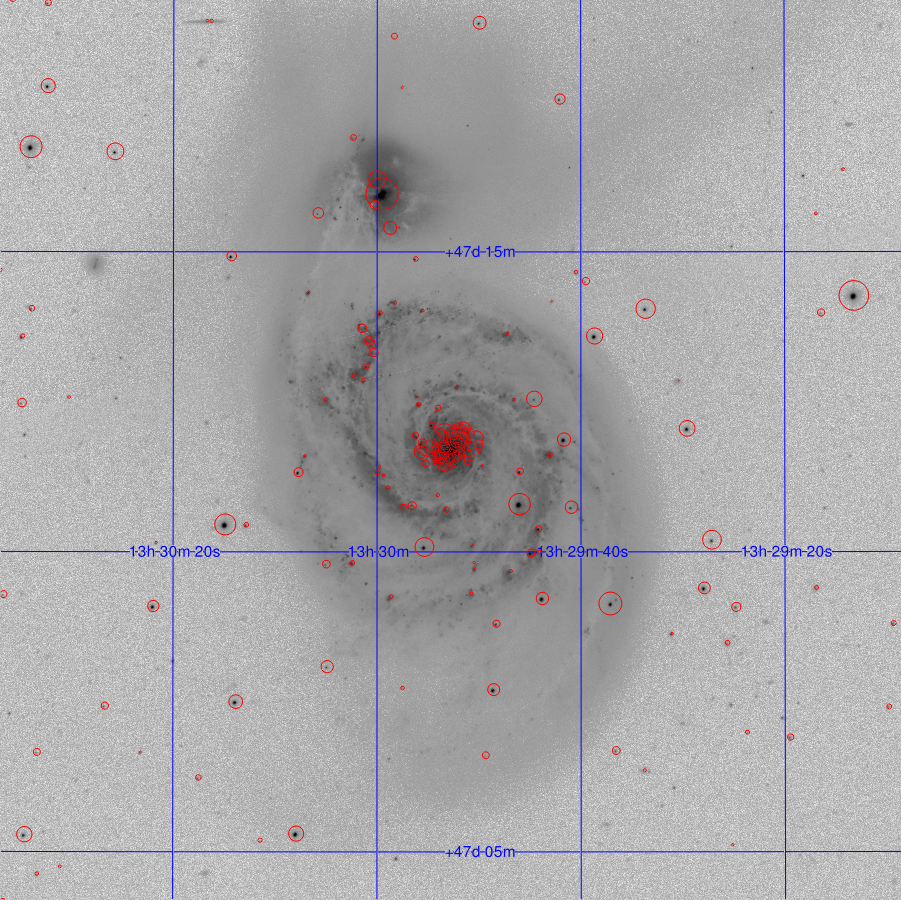

In [14]:
# Make a PNG rendering of the data and display it.

rtn = mViewer('''-ct 1 
                 -color blue
                 -grid equ j2000
                 -color red 
                 -symbol 1.0 circle 
                 -scalecol j_m 16.0 mag 
                 -catalog fp_2mass.tbl 
                 -gray uncorrected.fits -2s max gaussian-log -out uncorrected.png''',
               "", mode=2)

# rtn = mViewer('''-ct 1 
#                  -color blue
#                  -gray uncorrected.fits -2s max gaussian-log -out uncorrected.png''',
#                "", mode=2)

print("mViewer: " + str(rtn), flush=True)

Image(filename='uncorrected.png')

In [15]:
end = datetime.datetime.now()
print('End: ' + str(start))

runtime = end - start

print('\nTotal time: ' + str(runtime))

End: 2020-06-18 15:12:09.216045

Total time: 0:00:26.059039
